In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

87 classes with 3219 images in total


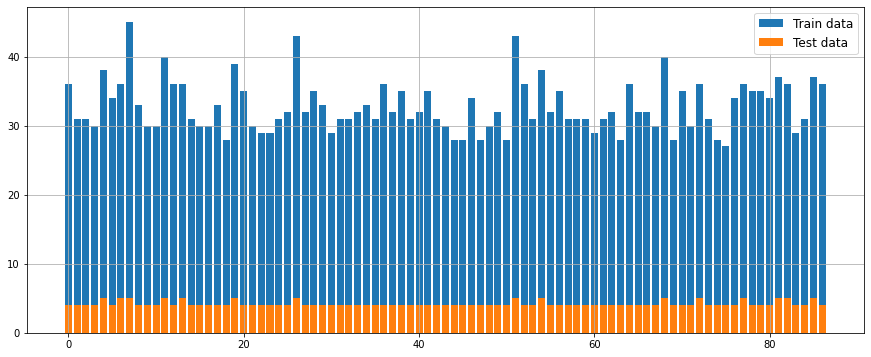

In [6]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('./archive'):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
            
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

In [7]:
img_w, img_h = 220, 220    # width and height of image
train_dir = './archive/train/'

In [9]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [10]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [11]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


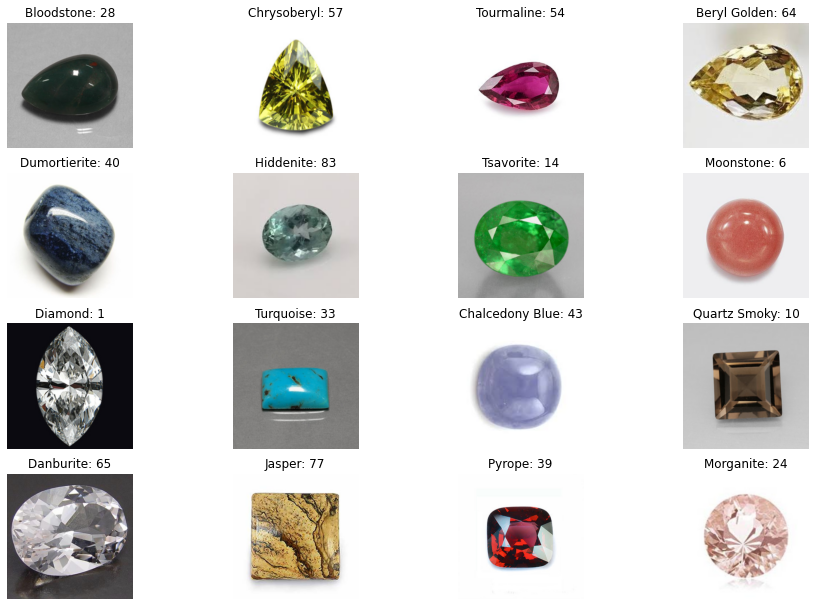

In [12]:
dim = 4 #you can change it;  4x4 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

In [13]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [14]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
            
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)

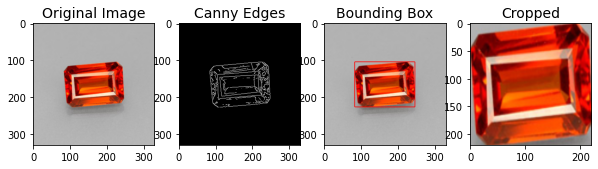

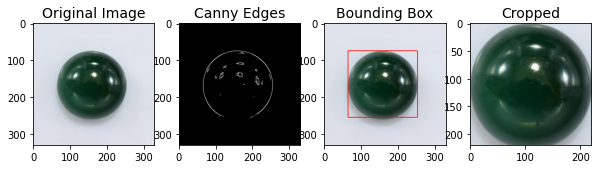

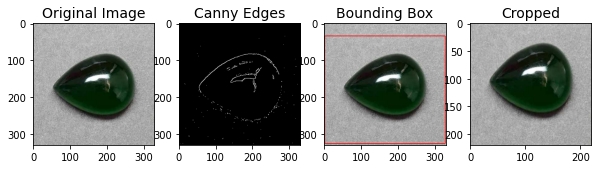

In [15]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

## 8. Replace train images with cropped images

- Create function which calls edge_and_cut and replaces Train_Imgs numpy array with array of cropped images. Don't forget that images that cannot be cropped will be replced with originals;

- Make sure the shape of final array is the same: NUMBER OF IMAGES x img_w x img_h x 3 (CHANNELS):

In [17]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [18]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


## 9. Split data into train and validation sets

- use sklearn to split Train_Imgs, Train_Lbls into train (80%) and validation (20%) sets. Important!

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284,) 
Shape of X_val: (572, 220, 220, 3), y_val: (572,) 


# III. Prepare for model creation

## 1. Check devices

#### 텐서 플로우를 사용하여 어떤 장치가 Kaggle 플랫폼을 사용하는지 확인한다.

- XLA_CPU 디바이스: CPU
- XLA_GPU 장치: Tesla P100-PCie-16GB(컴퓨팅을 가속화하려면 GPU 모드를 사용합니다.)
#### XLA는 가속 선형 대수를 나타냅니다. Tensorflow의 비교적 최적화된 컴파일러로 ML 모델의 속도를 더욱 높일 수 있습니다.

#### GPU 모드를 사용하여 이 노트북을 실행합니다 : 
for example, using image size 190 x 190 and basic architecture of CNN mentioned above every epoch on CPU takes ~3 minutes, on GPU ~ 15 sec.

In [21]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)


ModuleNotFoundError: No module named 'tensorflow'